# PESTPP-GLM

In this notebook, we will run PESTPP-GLM in standard parameter estimation mode and regularization mode.  In both cases, we will use the baked-in bayes-linear posterior monte carlo analysis to get posterior forecast PDFs.  We will use the prior monte carlo outputs as the prior forecast PDF.

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['font.size']=12
import flopy
import pyemu


flopy is installed in /Users/jeremyw/Dev/gw1876/activities_2day_mfm/notebooks/flopy


In [2]:
t_d = "template"
m_d = "master_glm"

In [3]:
pst = pyemu.Pst(os.path.join(t_d,"freyberg.pst"))
pst.write_par_summary_table(filename="none")

,type,transform,count,initial value,upper bound,lower bound,standard deviation
gr_prsity5,gr_prsity5,log,705,0,0.176091,-0.30103,0.11928
pp_rech0,pp_rech0,log,32,0,0.0413927,-0.0457575,0.0217875
gr_vka3,gr_vka3,log,705,0,1,-1,0.5
gr_ss4,gr_ss4,log,705,0,1,-1,0.5
cn_rech4,cn_rech4,log,1,0,0.0791812,-0.09691,0.0440228
cn_hk8,cn_hk8,log,1,0,1,-1,0.5
strk,strk,log,40,0,2,-2,1
cn_sy7,cn_sy7,log,1,0,0.243038,-0.60206,0.211275
gr_ss3,gr_ss3,log,705,0,1,-1,0.5
pp_strt0,pp_strt0,log,32,0,0.0211893,-0.0222764,0.0108664


### reduce the number of adjustable parameters

This is the painful part: we cant use 10K+ pars because we cant wait around for that many runs and then the linear algebra of factoring a 10k+ by 10K+ matrix is also difficult.  So that means we need to fix a lot a parameters #frownyface

In [4]:
par = pst.parameter_data

In [5]:
# grid-scale pars
gr_pars = par.loc[par.pargp.apply(lambda x: "gr" in x),"parnme"]
par.loc[gr_pars,"partrans"] = "fixed"
pst.npar_adj

719

In [6]:
# these are the sfr conductance parameters - Ive left all 40 adjustable
# but if you uncomment this, it will tie them into 1 parameter effectively
# strk_pars = par.loc[par.pargp=="strk","parnme"]
# p1 = strk_pars.iloc[0]
# par.loc[strk_pars.iloc[1:],"partrans"] = "tied"
# par.loc[strk_pars.iloc[1:],"partied"] = p1
pst.npar_adj

719

In [7]:
par.loc[par.pargp.apply(lambda x: "pp" in x),"pargp"].unique()

array(['pp_hk0', 'pp_hk1', 'pp_hk2', 'pp_prsity0', 'pp_prsity1',
       'pp_prsity2', 'pp_rech0', 'pp_rech1', 'pp_ss0', 'pp_ss1', 'pp_ss2',
       'pp_strt0', 'pp_strt1', 'pp_strt2', 'pp_sy0', 'pp_sy1', 'pp_sy2',
       'pp_vka0', 'pp_vka1', 'pp_vka2'], dtype=object)

Fix the storage pilot points - we still have layer-scale storage pars adjustable

In [8]:
#s_pars = par.loc[par.pargp.apply(lambda x: "pp" in x and ("ss" in x or "sy" in x)),"parnme"]
#par.loc[s_pars,"partrans"] = "fixed"
pst.npar_adj

719

In [9]:
adj_par = par.loc[par.partrans=="log",:]
adj_par.pargp.value_counts().sort_values()

cn_hk6          1
cn_sy6          1
cn_prsity8      1
cn_rech4        1
cn_hk8          1
cn_strt6        1
cn_ss7          1
cn_ss6          1
cn_strt7        1
cn_vka7         1
cn_sy8          1
flow            1
cn_prsity7      1
cn_sy7          1
cn_vka8         1
cn_prsity6      1
cn_rech5        1
cn_strt8        1
cn_ss8          1
cn_hk7          1
cn_vka6         1
welflux         2
welflux_k02     6
drncond_k00    10
pp_sy0         32
pp_prsity0     32
pp_prsity1     32
pp_strt0       32
pp_sy1         32
pp_strt1       32
pp_strt2       32
pp_vka2        32
pp_ss2         32
pp_prsity2     32
pp_hk1         32
pp_vka0        32
pp_sy2         32
pp_rech0       32
pp_ss1         32
pp_hk0         32
pp_hk2         32
pp_ss0         32
pp_vka1        32
pp_rech1       32
strk           40
Name: pargp, dtype: int64

fix the future recharge pilot points, vka in layers 1 and 3 and the initial condition pilot points (we still have layer-scale pars for each of these types)

In [10]:
fi_grps = ["pp_rech1","pp_vka0","pp_vka2","pp_strt0","pp_strt1","pp_strt2"]
par.loc[par.pargp.apply(lambda x: x in fi_grps),"partrans"] = "fixed"
pst.npar_adj

527

Ok, thats better...so lets run PESTPP-GLM.  We will use a single "base parameter" jacobian matrix as the basis for 6 super parameter iterations.  Then we will draw 100 realizations from the FOSM posterior parameter covariance matrix and run those 100 realizations to get the psoterior forecast PDFs

In [11]:
pst.control_data.noptmax = 3
pst.pestpp_options["n_iter_base"] = -1
pst.pestpp_options["n_iter_super"] = 3
pst.pestpp_options["num_reals"] = 50 # this is how many ies uses
pst.pestpp_options["parcov"] = "prior_cov.jcb"
pst.write(os.path.join(t_d,"freyberg_pp.pst"))

noptmax:3, npar_adj:527, nnz_obs:14


In [12]:
pyemu.os_utils.start_slaves(t_d,"pestpp-glm","freyberg_pp.pst",num_slaves=20,slave_root=".",
                           master_dir=m_d)

In [13]:
df = df=pd.read_csv(os.path.join(m_d,"freyberg_pp.post.obsen.csv"),index_col=0)
oe = pyemu.ObservationEnsemble.from_dataframe(pst=pst,df=df)

real_name
45     19.369533
34     20.846610
46     21.882157
11     22.353237
49     29.366309
8      32.918376
44     41.193909
30     46.635983
10     67.894886
38    121.187577
1     153.424546
29    169.305090
7     197.933663
21    234.861997
35    288.628727
33    296.265990
17    296.719869
41    348.978104
26    523.078249
20    555.670256
dtype: float64

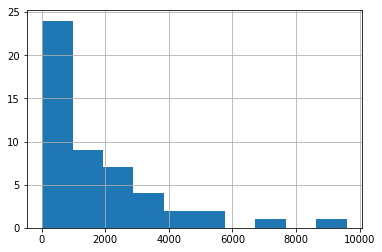

In [14]:
ax = oe.phi_vector.hist()#bins=np.linspace(0,100,20))
oe.phi_vector.sort_values().iloc[:20]

Here we see the distribution of phi values across the 100 posterior realizations.  Should we accept all of these???  The theoretical phi we should accept is number of nonzero obs (14).

To get a "posterior" ensemble, we need to throw out the realizations with large phi - lets just take the 20 best:

In [15]:
oe_pt = oe.loc[oe.phi_vector.sort_values().index[:20],:] #just take the 20 lowest phi realizations

We can also load and plot the FOSM forecast results along side of the ensemble results:

In [16]:
f_df = pd.read_csv(os.path.join(m_d,"freyberg_pp.pred.usum.csv"),index_col=0)
f_df.index = f_df.index.map(str.lower)
f_df

,prior_mean,prior_stdev,prior_lower_bound,prior_upper_bound,post_mean,post_stdev,post_lower_bound,post_upper_bound
name,,,,,,,,
fa_hw_19791230,-977.2390,295.32800,-1567.8900,-386.5840,-683.0780,257.446000,-1197.9700,-168.1850
fa_hw_19801229,-351.2160,409.77000,-1170.7600,468.3240,216.9670,349.390000,-481.8120,915.7460
fa_tw_19791230,-453.0330,409.35100,-1271.7400,365.6690,-122.8870,185.967000,-494.8220,249.0480
fa_tw_19801229,108.9600,506.73200,-904.5040,1122.4200,577.0510,277.727000,21.5971,1132.5100
hds_00_013_002_000,39.6102,3.96314,31.6840,47.5365,35.6590,0.371793,34.9155,36.4026
hds_00_013_002_001,38.3838,4.05782,30.2681,46.4994,34.7388,0.731605,33.2756,36.2020
part_status,2.0000,0.00000,2.0000,2.0000,1.0000,0.000000,1.0000,1.0000
part_time,907.7020,570.98600,-234.2690,2049.6700,4015.0000,443.065000,3128.8700,4901.1300


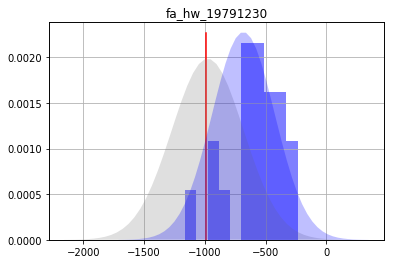

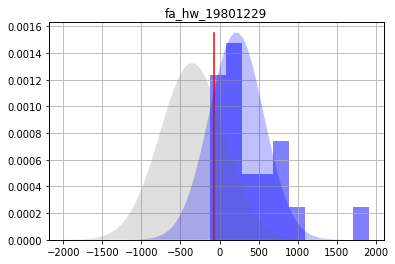

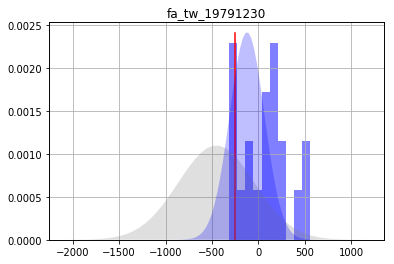

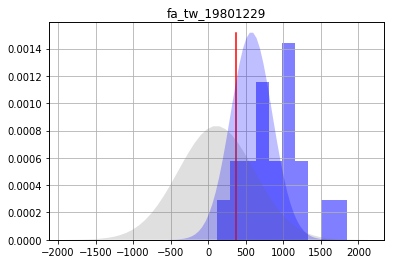

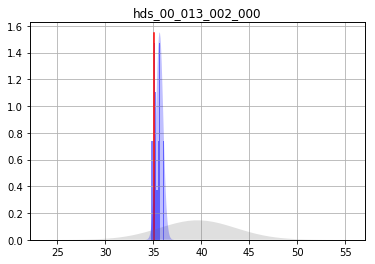

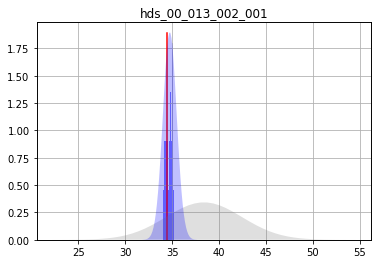

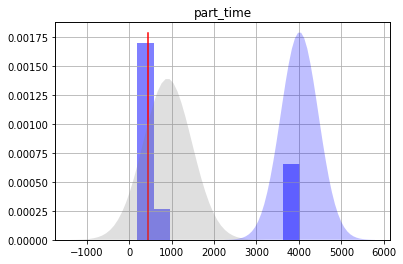

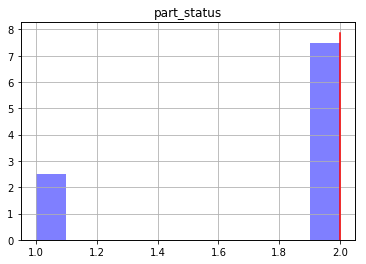

In [17]:
obs = pst.observation_data
fnames = pst.pestpp_options["forecasts"].split(",")
for forecast in fnames:
    ax = plt.subplot(111)
    oe_pt.loc[:,forecast].hist(ax=ax,color="b",alpha=0.5,normed=True)
    ax.plot([obs.loc[forecast,"obsval"],obs.loc[forecast,"obsval"]],ax.get_ylim(),"r")
    axt = plt.twinx()
    x,y = pyemu.plot_utils.gaussian_distribution(f_df.loc[forecast,"prior_mean"],f_df.loc[forecast,"prior_stdev"])
    axt.fill_between(x,0,y,facecolor="0.5",alpha=0.25)
    x,y = pyemu.plot_utils.gaussian_distribution(f_df.loc[forecast,"post_mean"],f_df.loc[forecast,"post_stdev"])
    axt.fill_between(x,0,y,facecolor="b",alpha=0.25)
    axt.set_ylim(0,axt.get_ylim()[1])
    axt.set_yticks([])
    ax.set_title(forecast)
    plt.show()

### Setup of Tikhonov regularization

Now lets setup and use some formal regularization to bring the final phi up to around 14.  We will use first-order regularization based on the covariance matrix we build earlier:

In [18]:
cov = pyemu.Cov.from_binary(os.path.join(t_d,"prior_cov.jcb"))

new binary format detected...


In [19]:
pyemu.helpers.first_order_pearson_tikhonov(pst,cov)

getting CC matrix
processing


In [20]:
pst.prior_information.head()

,equation,obgnme,pilbl,weight
pilbl,,,,
pcc_1,1.0 * log(dc0000390005) - 1.0 * log(dc0000390006) = 0.0,regul_cc,pcc_1,0.904837
pcc_2,1.0 * log(dc0000390005) - 1.0 * log(dc0000390007) = 0.0,regul_cc,pcc_2,0.818731
pcc_3,1.0 * log(dc0000390005) - 1.0 * log(dc0000390008) = 0.0,regul_cc,pcc_3,0.740818
pcc_4,1.0 * log(dc0000390005) - 1.0 * log(dc0000390009) = 0.0,regul_cc,pcc_4,0.670320
pcc_5,1.0 * log(dc0000390005) - 1.0 * log(dc0000390010) = 0.0,regul_cc,pcc_5,0.606531


In [21]:
shutil.copy2(os.path.join(m_d,"freyberg_pp.jcb"),os.path.join(t_d,"restart_pp.jcb"))


'template/restart_pp.jcb'

In [22]:
pst.pestpp_options["base_jacobian"] = "restart_pp.jcb"
pst.reg_data.phimlim = pst.nnz_obs
pst.reg_data.phimaccept = pst.reg_data.phimlim * 1.1
pst.write(os.path.join(t_d,"freyberg_pp.pst"))

noptmax:3, npar_adj:527, nnz_obs:14


In [23]:
pyemu.os_utils.start_slaves(t_d,"pestpp-glm","freyberg_pp.pst",num_slaves=20,slave_root=".",
                           master_dir=m_d)

In [24]:
df = df=pd.read_csv(os.path.join(m_d,"freyberg_pp.post.obsen.csv"),index_col=0)
oe = pyemu.ObservationEnsemble.from_dataframe(pst=pst,df=df)

real_name
49     12.211321
45     44.197023
11     70.946143
34     72.128879
20     80.509778
46    114.542769
44    134.483626
17    154.613525
10    163.211140
35    170.024936
30    170.247477
41    216.605116
37    293.688548
47    324.709679
7     344.635389
40    403.592937
1     408.648229
8     430.019036
13    448.043824
21    456.891746
dtype: float64

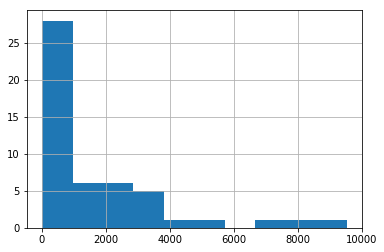

In [25]:
ax = oe.phi_vector.hist()#bins=np.linspace(0,100,20))
oe.phi_vector.sort_values().iloc[:20]

Same as before, to get a "posterior" ensemble, we need to throw out the realizations with large phi - lets just take the 20 best:

In [26]:
oe_pt = oe.loc[oe.phi_vector.sort_values().index[:20],:] 

In [27]:
f_df = pd.read_csv(os.path.join(m_d,"freyberg_pp.pred.usum.csv"),index_col=0)
f_df.index = f_df.index.map(str.lower)
f_df

,prior_mean,prior_stdev,prior_lower_bound,prior_upper_bound,post_mean,post_stdev,post_lower_bound,post_upper_bound
name,,,,,,,,
fa_hw_19791230,-977.2390,295.32800,-1567.8900,-386.5840,-797.5000,259.781000,-1317.06000,-277.9390
fa_hw_19801229,-351.2160,409.77000,-1170.7600,468.3240,15.1497,353.117000,-691.08300,721.3830
fa_tw_19791230,-453.0330,409.35100,-1271.7400,365.6690,-109.3180,186.415000,-482.14700,263.5120
fa_tw_19801229,108.9600,506.73200,-904.5040,1122.4200,562.1340,277.838000,6.45674,1117.8100
hds_00_013_002_000,39.6102,3.96314,31.6840,47.5365,35.9870,0.462778,35.06140,36.9125
hds_00_013_002_001,38.3838,4.05782,30.2681,46.4994,34.9912,0.779721,33.43180,36.5507
part_status,2.0000,0.00000,2.0000,2.0000,1.0000,0.000000,1.00000,1.0000
part_time,907.7020,570.98600,-234.2690,2049.6700,4015.0000,443.279000,3128.44000,4901.5600


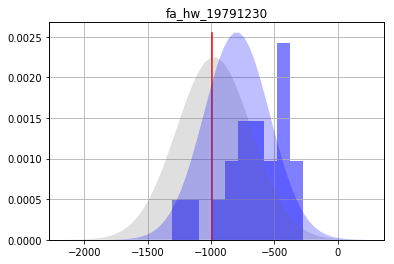

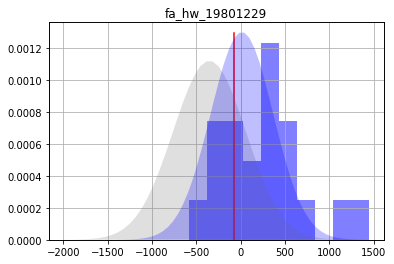

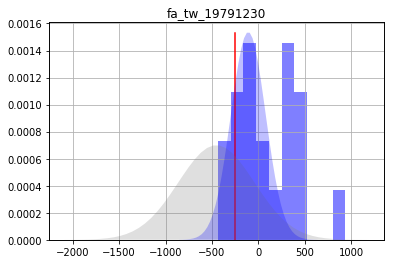

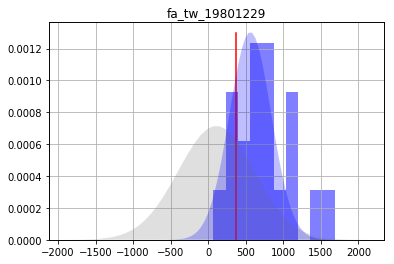

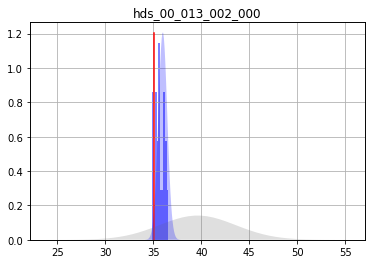

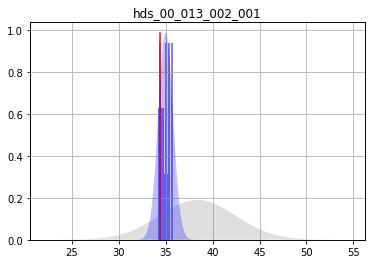

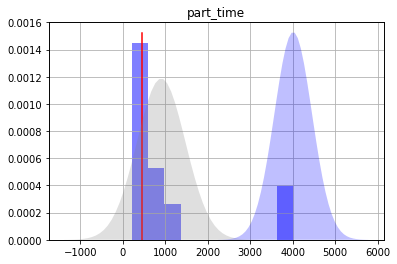

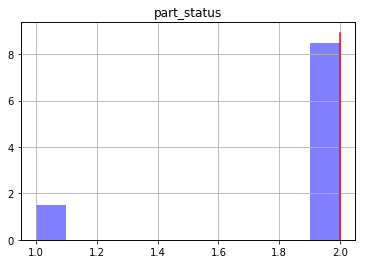

In [28]:
obs = pst.observation_data
fnames = pst.pestpp_options["forecasts"].split(",")
for forecast in fnames:
    ax = plt.subplot(111)
    oe_pt.loc[:,forecast].hist(ax=ax,color="b",alpha=0.5,normed=True)
    ax.plot([obs.loc[forecast,"obsval"],obs.loc[forecast,"obsval"]],ax.get_ylim(),"r")
    axt = plt.twinx()
    x,y = pyemu.plot_utils.gaussian_distribution(f_df.loc[forecast,"prior_mean"],f_df.loc[forecast,"prior_stdev"])
    axt.fill_between(x,0,y,facecolor="0.5",alpha=0.25)
    x,y = pyemu.plot_utils.gaussian_distribution(f_df.loc[forecast,"post_mean"],f_df.loc[forecast,"post_stdev"])
    axt.fill_between(x,0,y,facecolor="b",alpha=0.25)
    axt.set_ylim(0,axt.get_ylim()[1])
    axt.set_yticks([])
    ax.set_title(forecast)
    plt.show()